In [ ]:
## Cross Slope mass transport in OM2-01 run

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

session = cc.database.create_session()

In [9]:
experiment = '01deg_jra55v13_ryf9091' # Purely for reference
lat_range = slice(-79, -56)

yt_ocean = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_month.nc')
yt_ocean = yt_ocean['yt_ocean'].sel(yt_ocean = lat_range)

xt_ocean = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_month.nc')
xt_ocean = xt_ocean['xt_ocean']

yu_ocean = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_month.nc')
yu_ocean = yu_ocean['yu_ocean'].sel(yu_ocean = lat_range)

xu_ocean = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_month.nc')
xu_ocean = xu_ocean['xu_ocean']

In [10]:
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

In [11]:
start_time = '1900-01-01' 
end_time = '1900-12-31'
time_slice = slice(start_time, end_time)
bath = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_grid.nc')
bath=bath.ht
# select one year and latitude range
bath_mean = bath.sel(yt_ocean = lat_range)

contour_depth = 1000
h = bath_mean.load()

# Fill in land with zeros:
h = h.fillna(0)

In [12]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean

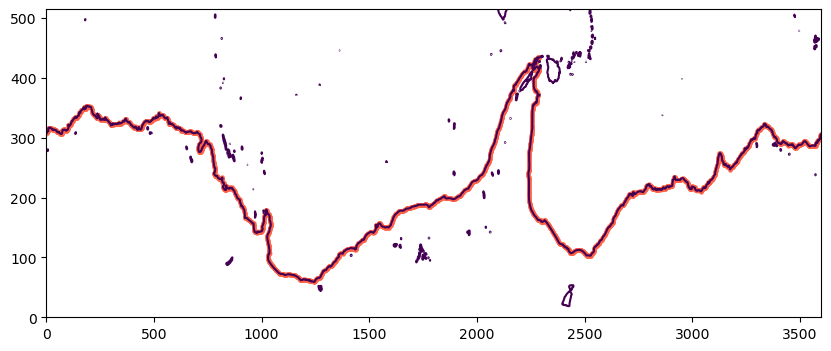

In [13]:
fig = plt.figure(figsize = (10, 4))
count = 1
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count ==  2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [14]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [15]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [16]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

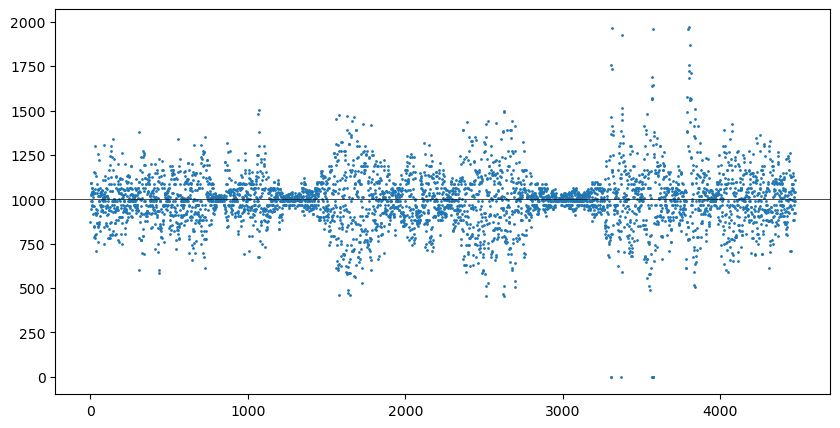

In [17]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [18]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

In [19]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [20]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

In [21]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

In [22]:
contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

In [23]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

In [25]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

In [27]:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims = ['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims = ['y_ocean','x_ocean'])

In [28]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [179]:
# FOr my simulations we dont have surface temp., so I have to get the st_ocean=0 of every temp
#%%time
ρ0 = 1035 # kg/m^3
import glob
src = '/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m/wf4500/access-om2/archive/ryf/output0'
gl =glob.glob(src + "**/ocean/ocean_month.nc")
gl=sorted(gl)
#print("%i netcdf data files"%len(gl))
##importing data from ocean.nc
tx_trans=xr.open_mfdataset(gl, concat_dim='time', combine='nested').tx_trans_int_z
ty_trans=xr.open_mfdataset(gl, concat_dim='time', combine='nested').ty_trans_int_z

tx_trans = tx_trans.sel(time=slice(start_time,end_time))/ρ0
ty_trans = ty_trans.sel(time=slice(start_time,end_time))/ρ0

ty_trans = ty_trans.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
tx_trans = tx_trans.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})

In [180]:
%%time
#import logging
#logging.captureWarnings(True)
#logging.getLogger('py.warnings').setLevel(logging.ERROR)
#logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)
## We could also loop in time if we didn't want the time average. 

# stack transports into 1d and drop any points not on contour:
x_transport_1d = tx_trans.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = ty_trans.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

CPU times: user 18.3 s, sys: 2.68 s, total: 20.9 s
Wall time: 20.1 s


In [181]:
%%time
# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()


CPU times: user 7.09 s, sys: 337 ms, total: 7.42 s
Wall time: 8.18 s


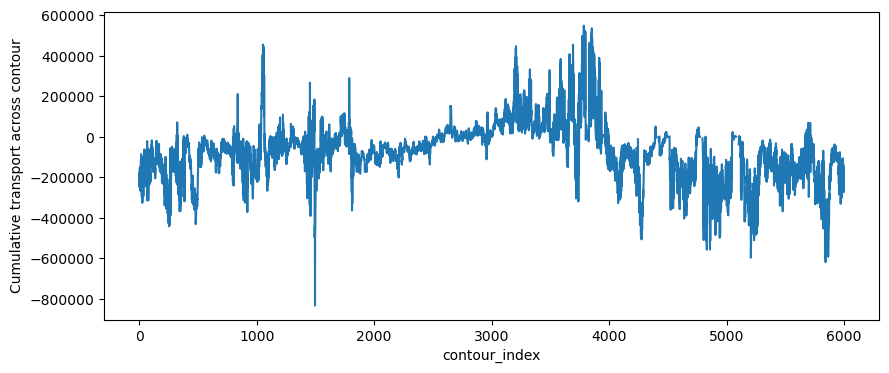

In [183]:
fig, ax = plt.subplots(figsize = (10, 4))

vol_trans_across_contour.mean(dim='time').plot()
ax.set_ylabel('Cumulative transport across contour');

In [184]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [46]:
%%time

dxu = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_grid.nc')
dxu = dxu['dxu'].sel(yu_ocean = lat_range)

dyt = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_grid.nc')
dyt = dyt['dyt'].sel(yt_ocean = lat_range)

num_points = len(lat_along_contour)

CPU times: user 48.7 ms, sys: 10.1 ms, total: 58.8 ms
Wall time: 50.6 ms


In [162]:
from geopy.distance import geodesic as GD
lat_along_contour2=lat_along_contour
lon_along_contour2=lon_along_contour


lat_along_contour2=np.append(lat_along_contour2,lat_along_contour[0])
lon_along_contour2=np.append(lon_along_contour2,lon_along_contour[0]+360)

distances_across=np.zeros(5998)
for n in range(5998):
    n0=int(n)

    distance_along_contour[n0] = GD((lat_along_contour2[n0],lon_along_contour2[n0]) ,(lat_along_contour2[n0+1],lon_along_contour2[n0+1])).km/1e3

In [163]:
distance_along_contour = np.cumsum(distance_along_contour)
distance_along_contour

array([3.26864336e-03, 6.53858458e-03, 1.10776235e-02, ...,
       2.50405623e+01, 2.50438297e+01, 2.50483612e+01])

In [48]:
distance_indices = np.zeros(8)

for i in np.arange(100, len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]

distance_indices[7] = len(lon_along_contour.contour_index.values)-1

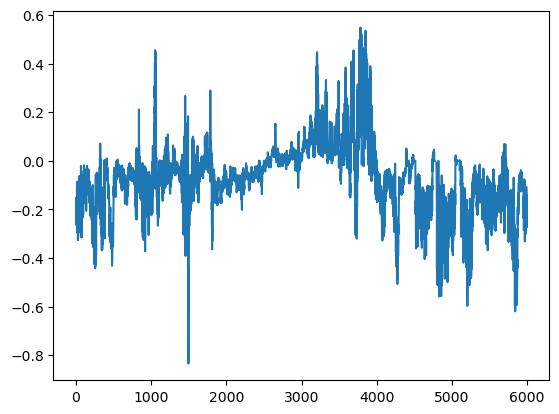

2023-05-01 17:15:34,690 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:34,809 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:34,813 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:34,914 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:35,123 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:35,127 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:35,211 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:36,133 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:36,138 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:36,220 - distributed.nanny - WARNING - Restarting worker
2023-05-01 17:15:38,921 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/82276571.gadi-pbs/dask-worker-space/worker-z7mu_yt5', purging
2023-05-01 17:15:38,921 - distributed.diskutils - INFO - Found stale lock file and directory '/jo

In [197]:
vol_trans_across_contour_mean=vol_trans_across_contour.mean(dim='time')
plt.plot(vol_trans_across_contour_mean*1e-6)

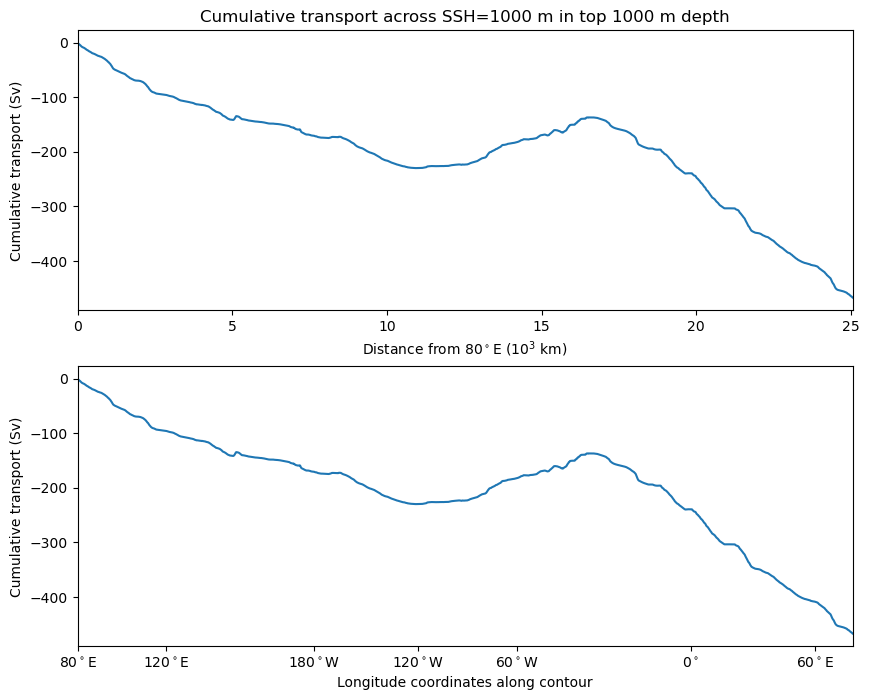

In [186]:
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour_mean.cumsum('contour_index')))

axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across SSH={contour_depth} m in top {depth_to_integrate} m depth')

axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour_mean.cumsum('contour_index')))

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (Sv)');

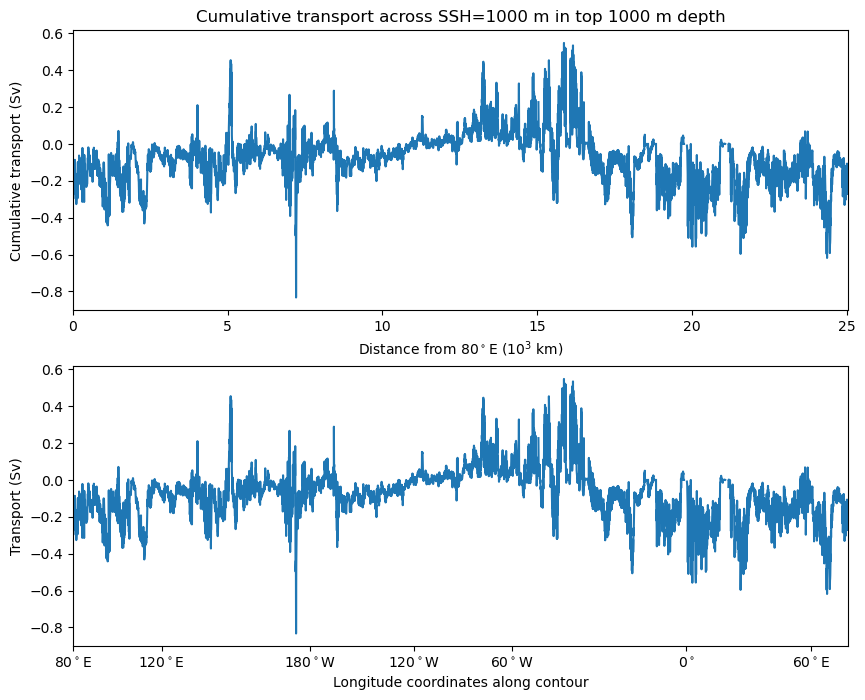

In [187]:
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour_mean))

axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across SSH={contour_depth} m in top {depth_to_integrate} m depth')

axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour_mean))

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Transport (Sv)');